
## About this project

We want a csv with data about most sold products in amazon, because we want to check in another websites if this products are cheaper and we can re-sell in amazon. To do this, we need specific information like the product model,brand,price, merchants, how often is sold, etc.

I will scrap in a specific main category of products (I already know some other sites selling this products with cheaper prices :D ). 

Technologies used:
- Selenium
- BeautifulSoup (utils.py)
- Pandas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from selenium import webdriver
import pandas as pd
import time
import random
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../'))
from utils import (soup_content_from_url,
                    elements_from_soup_bestsellers_web, 
                    subcategories_from_bestsellers_web,
                    detail_dict_from_product_page,
                    load_obj,
                    save_obj)

# EDA

Estadisticos:
* Describe district
* 

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
filename = "out-venta-casas.csv"
filename = "out-venta-lotes-y-terrenos.csv"
df = pd.read_csv(filename)
df.head(3)

,ref_id,neighborhood,district,province,currency,amount,price,url,description,property_type,...,recent_id,scrapped_date,totalArea,floorArea,bedrooms,bathrooms,garage,has_gas,has_water,has_electricity
0,inmueble-71779-71,Primitivo de la Reta y Alsina,Godoy Cruz,Mendoza,US$,560000.0,US$ 560.000,https://www.inmoclick.com.ar/71779-greenwood/i...,GREENWOOD VENDE EN GODOY CRUZ ESPECTACULAR TER...,PropertyType.LAND,...,1,2020-06-01 00:53:03.463198,2800,NaN,NaN,NaN,NaN,True,True,True
1,inmueble-71779-65,Pinares de Furlotti,Maipu,Mendoza,US$,20000.0,US$ 20.000,https://www.inmoclick.com.ar/71779-greenwood/i...,GREENWOOD VENDE OPORTUNIDAD INCREIBLE\n\nPINAR...,PropertyType.LAND,...,2,2020-06-01 00:53:03.466060,350,NaN,NaN,NaN,NaN,True,True,True
2,inmueble-4586-25,Barrio rincón del cerro,Godoy Cruz,Mendoza,US$,18000.0,US$ 18.000,https://www.inmoclick.com.ar/4586-catania/inmu...,-Catania vende- lotes desde 200 hasta 282 metr...,PropertyType.LAND,...,3,2020-06-01 00:53:03.468793,208,NaN,NaN,NaN,NaN,True,True,True


Metricas a calcular:
	
    Estadisticos:
		Cantidad total
		Precio promedio
		Precio mediano
		Dispersion(p99, p1, desviacion tipica)
	Abiertas por:
		* Gran Mendoza(General)
		* Departamentos(chacras separado)
		* Inmobiliaria
		* Tipo de precio (Dolar, Peso, no se sabe)
		* Tipo de inmueble (Lote, Departamento, Casa)
		* *Rango de interes*

	Rangos de interes segun inmueble:
		Lotes - Tamaño m2::
			- 0..300
			- 300..500
			- 500..1000
			- 1000..
		Departamentos - Tamaño m2:
			- 90..120
			- 120..240
			- 240..
		Casas - Superficie cubierta m2:
			- 40..60
			- 60..90
			- 90..

In [17]:
df.currency = df.currency.fillna('consultar')

In [47]:
df.district.unique()
gran_mendoza_list = ['Godoy Cruz', 'Maipu', 'Lujan de Cuyo', 'Las Heras', 'Capital',
       'Carrodilla', 'Guaymallen', 'Chacras de Coria',
       'Vistalba', 'Mayor Drummond', 'Perdriel', 'La Puntilla']
df = df[df.district.isin(gran_mendoza_list)]

## Tipo de inmuebles : Lotes y Terrenos

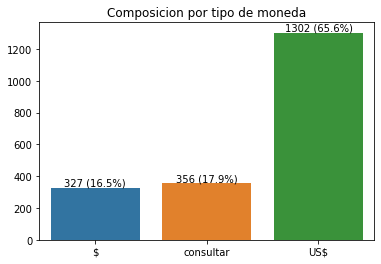

In [48]:
curr = df.groupby('currency').count().ref_id.sort_values()
share = round(curr/curr.sum()*100,1)
g = sns.barplot(x=curr.index.values,y=curr.values)
for i,row in enumerate(curr.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i,row[1], bar_text, color='black', ha="center",va='bottom')
    
g.set_title('Composicion por tipo de moneda')
plt.show()

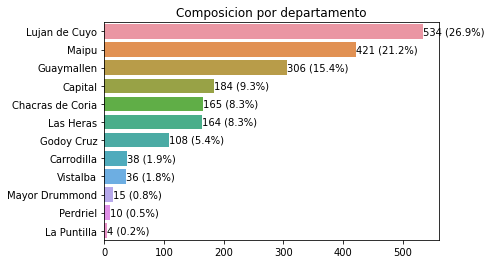

In [49]:
districts = df.groupby('district').count().ref_id.sort_values(ascending=False)
share = round(districts/districts.sum()*100,1)
g = sns.barplot(x=districts.values,y=districts.index.values)

for i,row in enumerate(districts.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por departamento')
plt.show()

### Creating totalArea ranges

In [50]:
# Fixing types
#df = df[df['totalArea']!='disable']
df['totalArea_fixed'] = df.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df.totalArea_fixed = df.totalArea_fixed.str.strip()
df.totalArea_fixed = df.totalArea_fixed.str.replace(',', '.')
df.totalArea_fixed = pd.to_numeric(df.totalArea_fixed, errors='coerce')

In [51]:
"""
Lotes - Tamaño m2::
        - 0..300
        - 300..500
        - 500..1000
        - 1000..
"""
        
df.loc[df.totalArea_fixed <= 300,'land_range'] = 0
df.loc[np.logical_and(df.totalArea_fixed > 300, df.totalArea_fixed <= 500),'land_range'] = 300
df.loc[np.logical_and(df.totalArea_fixed > 500, df.totalArea_fixed <= 1000),'land_range'] = 500
df.loc[df.totalArea_fixed > 1000,'land_range'] = 1000
ranges = ['0..300','300..500','500..1000','1000..']

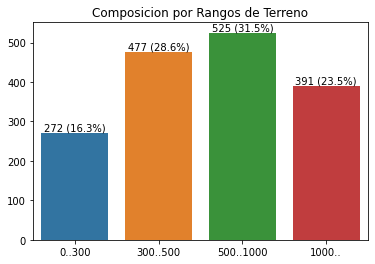

In [52]:
land_range = df.groupby('land_range').count().ref_id#.sort_values(ascending=False)
share = round(land_range/land_range.sum()*100,1)
g = sns.barplot(x=ranges, y=land_range.values)

for i,row in enumerate(land_range.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(i, row[1], bar_text, color='black', ha="center",va='bottom',rotation=0)
g.set_title('Composicion por Rangos de Terreno')
plt.show()

total agencies:194


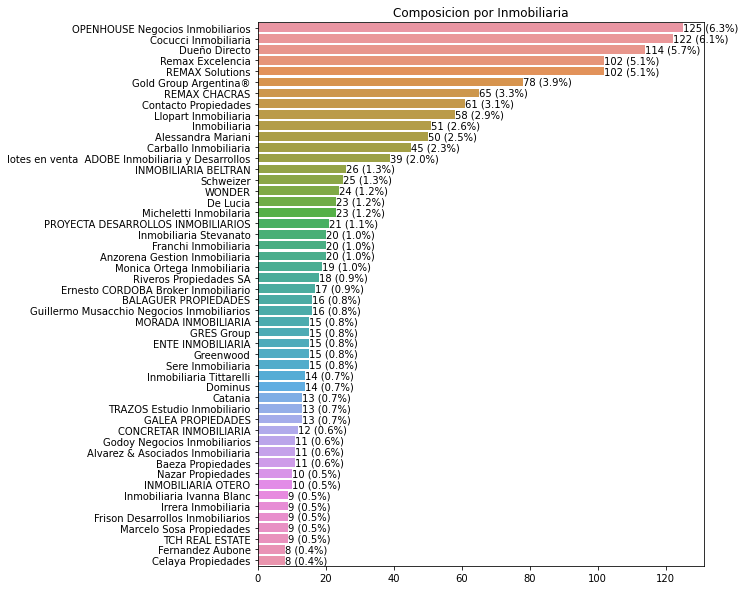

In [54]:
agency = df.groupby("agency").count().ref_id.sort_values(ascending= False)
share = round(agency/agency.sum()*100,1)
print("total agencies:"+str(len(agency)))

agency = agency.head(50)
plt.figure(figsize=(8,10))
g = sns.barplot(x=agency.values, y=agency.index.values)

for i,row in enumerate(agency.iteritems()):
    bar_text = f'{row[1]} ({share.iloc[i]}%)'
    g.text(row[1],i, bar_text, color='black', ha="left",va='center',rotation=0)
g.set_title('Composicion por Inmobiliaria')
plt.show()

In [60]:
df["squared_meter_amount"] = df.amount/df.totalArea_fixed

In [77]:
#district_landr = (df[df['currency']=='US$'].groupby(["district","land_range"])
#.agg({'squared_meter_amount':['mean'],'ref_id':['count']}))
pd.pivot_table(df[df['currency']=='US$'],
               values=['squared_meter_amount','ref_id'],
               index='district',
               columns='land_range',
               aggfunc={'squared_meter_amount':'mean',
                        'ref_id':'count'})

ref_id                      squared_meter_amount              \
land_range       0.0    300.0  500.0  1000.0               0.0         300.0    
district                                                                        
Capital            35.0   38.0   45.0    3.0           310.639663  241.505310   
Carrodilla          5.0   20.0    4.0    1.0           108.234409   80.776118   
Chacras de Coria    1.0   22.0   74.0   32.0            48.872180   89.140842   
Godoy Cruz         16.0   19.0   27.0   10.0           141.675694  184.124169   
Guaymallen         28.0   32.0   33.0   30.0           812.304654  117.872367   
La Puntilla         NaN    1.0    1.0    NaN                  NaN  131.229236   
Las Heras          14.0   26.0   19.0   27.0          1280.086473  108.336081   
Lujan de Cuyo      23.0   69.0  107.0   78.0          7245.007731   67.932562   
Maipu              30.0  115.0   61.0   46.0            73.465982   66.912244   
Mayor Drummond      3.0    6.0    4.0    NaN           133.758436   69.940871   
Perdriel            2.0    NaN    2.0    4.0            62.500000         NaN   
Vistalba            1.0    1.0   10.0   16.0             0.435610   59.000000   

                                           
land_range            500.0        1000.0  
district                                   
Capital           232.073018  1124.992126  
Carrodilla         43.753211    30.000000  
Chacras de Coria   98.424671   115.493487  
Godoy Cruz        184.008012   310.817990  
Guaymallen         99.975877    58.829123  
La Puntilla        99.848714          NaN  
Las Heras         104.105650    13.704200  
Lujan de Cuyo      75.097640    37.465077  
Maipu              56.549647    37.783528  
Mayor Drummond     53.414903          NaN  
Perdriel           53.631033    16.035368  
Vistalba           74.003020    39.716215

### Abierto por departamentos

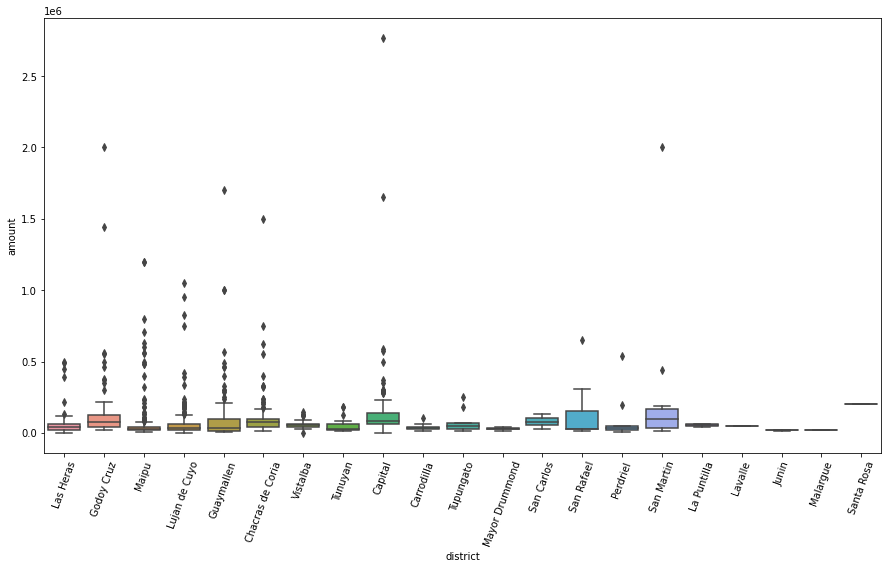

In [32]:
plt.figure(figsize=(15,8))
g = sns.boxplot(x=df[df.currency=='US$']['district'], y=df['amount'])
g.set_xticklabels(g.get_xticklabels(),rotation=70)
plt.show()

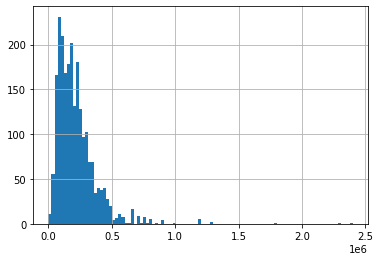

In [158]:
df[df.currency=='US$'].amount.hist(bins=100)

In [21]:
import numpy as np
#df[np.logical_and(df['amount']<30000,df['amount']>0)].sort_values(by='amount')
df[df.description.str.contains("2018")].description

34      Gold Group Argentina® vende!!\nEstupenda casa ...
43      CASA TOTALMENTE RECICLADA 2018.\nPropiedad ubi...
75      Gold Group Argentina® Vende!!\nConfortable cas...
76      Gold Group Argentina® Vende!!\nOportunidad!!\n...
77      Gold Group Argentina® vende!!\nMagnífica casa ...
                              ...                        
3043    COCUCCI INMOBILIARIA VENDE CASA EN BARRIO PRIV...
3079    COCUCCI INMOBILIARIA VENDE: CASA RUSTICA, SOBR...
3089    COCUCCI INMOBILIARIA VENDE HERMOSA CASA EN EL ...
3123    Gold Group Vende!\nEstupenda quinta emplazada ...
3175    GOLD GROUP ARGENTINA® VENDE!!\nMARAVILLOSA CAS...
Name: description, Length: 158, dtype: object

In [22]:
str(df[df.index==3175].url.values)

"['https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/939/ficha/casa-en-venta-en-rincon-de-araoz-lujan-de-cuyo?btid=2465480']"

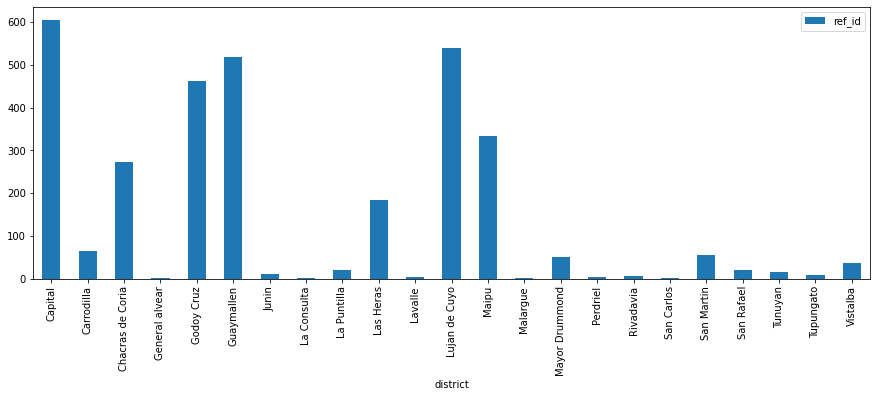

In [177]:
df.groupby('district').count().plot.bar(y='ref_id',figsize=(15,5))

In [33]:
dfdol = df[df.currency=='US$'].reset_index(drop=True)
dfdol['r_10'] = round(dfdol.recent_id/100)
h = dfdol.groupby('r_10').mean()
#pd.pivot_table(h,values,index='r_10',columns,aggfunc)

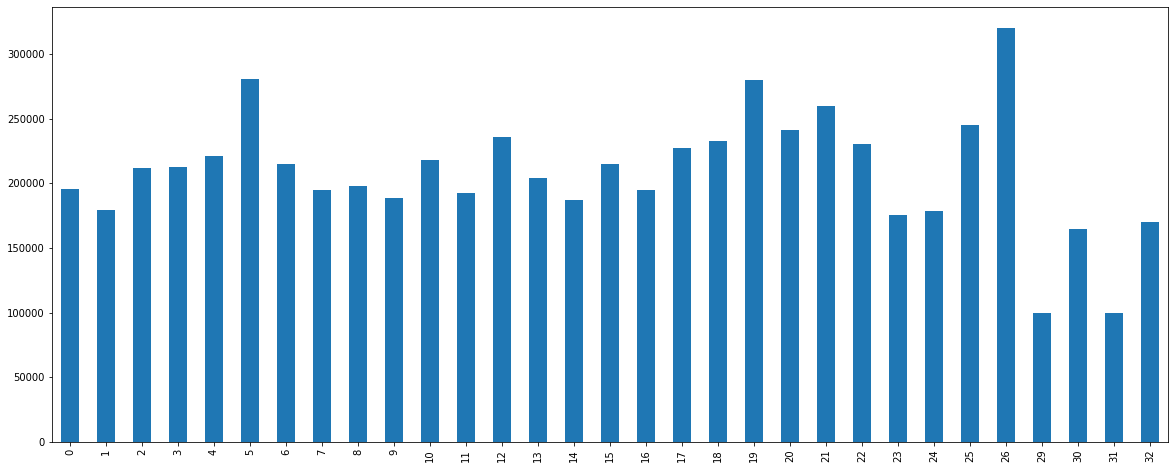

In [34]:
plt.figure(figsize=(20,8))
h.index = h.index.astype(int)
h['amount'].plot.bar()

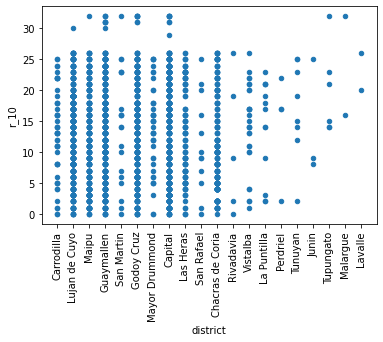

In [42]:
dfdol.plot.scatter(x='district',y='r_10',rot=90)

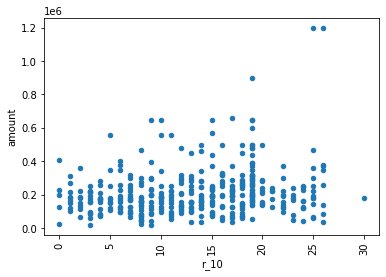

In [46]:
dfdol[dfdol.district=='Lujan de Cuyo'].plot.scatter(x='r_10',y='amount',rot=90)

In [68]:
import numpy as np
pd.set_option('display.max_columns', 30)
list(dfdol[dfdol['r_20']==3].url)

['https://www.inmoclick.com.ar/71779-greenwood/inmuebles/82/ficha/casa-en-venta-en-acceso-este-y-arturo-gonzalez?btid=2465480',
 'https://www.inmoclick.com.ar/71779-greenwood/inmuebles/84/ficha/casa-en-venta-en-juan-agustin-maza-y-azcuenaga?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1479/ficha/casa-en-venta-en-b0-privado-bucci-bandera-de-los-andes-y-rosario?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1500/ficha/casa-en-venta-en-laguna-horcones-1054-barrio-fuchs?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1508/ficha/casa-en-venta-en-vicente-gil-539?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1515/ficha/casa-en-venta-en-rufino-ortega-y-martinez-de-rozas?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-group-argentina/inmuebles/1518/ficha/casa-en-venta-en-p-benegas-691?btid=2465480',
 'https://www.inmoclick.com.ar/17636-gold-g

In [175]:
df2 = df[df['totalArea']!='disable']
df2.totalArea = df2.totalArea.str.replace('mts2','').str.replace('m2','').str.replace('m','')
df2.totalArea = df2.totalArea.str.strip()
df2 = df2[~df2['totalArea'].str.contains('2.852.61')]
df2.totalArea = df2['totalArea'].str.replace(',','.')

In [176]:
df2.totalArea = df2.totalArea.astype(float)

In [177]:
df2.floorArea[df2.floorArea.str.contains('\,')]

295     301,24m2
1142     57,78m2
1144     80,00m2
1204    411,00m2
1427    69,10 m2
1475    65,83 m2
1484       334,3
1675       97,15
1759    453,85m2
1760    258,32m2
1800      135,53
2006      170,47
2083    221,50m2
3038       483,6
3074      299,35
3089    313,58m2
Name: floorArea, dtype: object

In [178]:
df2 = df2[df2['floorArea']!='disable']
df2 = df2[df2['floorArea']!='140/60']
df2.floorArea = (df2.floorArea.str.replace('mts2','')
                             .str.replace('m2','')
                             .str.replace('m','')
                             .str.replace('aprox.con cocher','')
                             .str.replace('aprox.','')
                             .str.replace(',',''))
df2.floorArea = df2.floorArea.astype(float)

In [179]:
df2.loc[df2['totalArea'] >= 4000,'totalArea']=4000

In [205]:
chacras = df2[np.logical_and(df2['district']=='Chacras de Coria',df2.currency=='US$')]

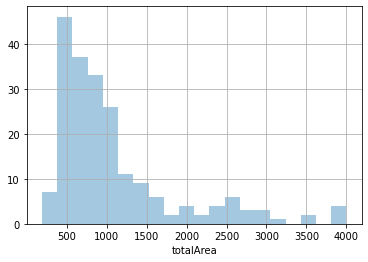

In [232]:
import seaborn as sns
g = sns.distplot(chacras.totalArea,bins=20,kde=False)
g.grid()

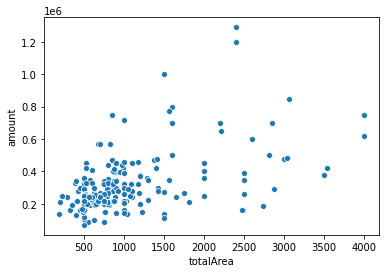

In [208]:
sns.scatterplot(x="totalArea", y="amount", data=chacras)

In [230]:
chacras['amountr'] = pd.qcut(chacras.amount,5)

/home/chanchus/developments/amz-scrapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


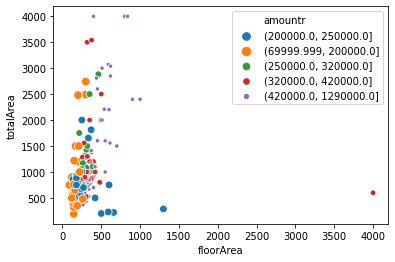

In [231]:
sns.scatterplot(x="floorArea", y="totalArea",hue="amountr", size="amountr", data=chacras)

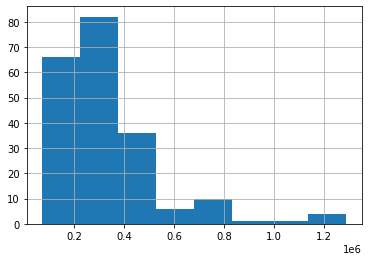

In [217]:
chacras.amount.hist(bins=8)

In [2]:
import pandas as pd

In [5]:
df1 = pd.DataFrame([['Buenos Aires',63,16,89,55],
				['Atlanta',17,29,81,17],
				['Brasil',88,82,9, 64]])
df1.columns=['Airport','A','B','C','D']
df1 = df1.set_index('Airport')

df2 = pd.DataFrame([['Buenos Aires',21,38,36],
		['Atlanta',54,88,80],
		['Brasil',44,53,53],
		['Madrid',24,58,29]])
df2.columns=['Airport','B','C','D']
df2 = df2.set_index('Airport')


,B,C,D
Airport,,,
Buenos Aires,21,38,36
Atlanta,54,88,80
Brasil,44,53,53
Madrid,24,58,29


In [6]:
df1.merge(df2, left_index=True,right_index=True)

,A,B_x,C_x,D_x,B_y,C_y,D_y
Airport,,,,,,,
Buenos Aires,63,16,89,55,21,38,36
Atlanta,17,29,81,17,54,88,80
Brasil,88,82,9,64,44,53,53
